### Portfolio

# Learning of Structured Data

### – Sheet 3 –

This assignment was created by:
- Anastasiia Demidova   (anastasiia.demidova@study.thws.de) - k67881.
- Mark Erokhin (mark.erokhin@study.thws.de) - k68532;


Github link: https://github.com/stDem/Motions_classification


## Exercise 1: (Data) Loading & Visualization

In [1]:
#import nesessary liblraries:
import os
import csv
import random
import matplotlib.pyplot as plt
import numpy as np
import subprocess
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
path_train="./data/train"
path_test="./data/test"
valid_actions = {"boxing", "drums", "guitar", "rowing", "violin"}

keypoint_names = {
    "0": "Nose", 
    "1": "Neck", 
    "2": "RShoulder", 
    "3": "RElbow", 
    "4": "RWrist",
    "5": "LShoulder", 
    "6": "LElbow", 
    "7": "LWrist", 
    "8": "MidHip", 
    "9": "RHip",
    "10": "RKnee", 
    "11": "RAnkle", 
    "12": "LHip", 
    "13": "LKnee", 
    "14": "LAnkle",
    "15": "REye", 
    "16": "LEye", 
    "17": "REar", 
    "18": "LEar", 
    "19": "LBigToe",
    "20": "LSmallToe", 
    "21": "LHeel", 
    "22": "RBigToe", 
    "23": "RSmallToe", 
    "24": "RHeel"
}

angle_names = ["R_Elbow_Angle", "R_Armpit_Angle", "L_Elbow_Angle", "L_Armpit_Angle"]

In [3]:
# class initialization:

class Dataset:
    def __init__(self, path_train, path_test):
        self.data = {"train": {}, "test": {}} # store data in a dictionary
        self._load_data(path_train, "train") # load train data
        self._load_data(path_test, "test") # load test data
        
    # loads the .csv files in data/train/ and data/test/:
    def _load_data(self, directory, dataset_type):
        for file_name in os.listdir(directory): # use listdir to get filenames in nesessary folder
            if file_name.endswith(".csv"): # take files only with .csv extention
                subject, action, iteration = self._parse_file_name(file_name) # to split the file name into subject, action, and iteration
                if action not in valid_actions: # check that isn't used invalid action
                    raise ValueError(f"Invalid action '{action}' in file '{file_name}'. Allowed actions: {valid_actions}")

                file_path = os.path.join(directory, file_name) # create the path to the nesessary file
                sequence = self._load_csv(file_path) # load data to get nesessary sequence

            # add sequence into the data dictionary:
                if subject not in self.data[dataset_type]:
                    self.data[dataset_type][subject] = {}
                if action not in self.data[dataset_type][subject]:
                    self.data[dataset_type][subject][action] = {}

                self.data[dataset_type][subject][action][iteration] = sequence

    # get subject, action, and iteration using filename:
    def _parse_file_name(self, file_name):
        base_name = file_name.rsplit(".", 1)[0] # get name before .csv
        subject, action, iteration = base_name.split("_") # split remaining filename into  subject, action, and iteration
        return subject, action, iteration

    # read nesessary file row by row:
    def _load_csv(self, file_path):
        sequence = []
        with open(file_path, "r") as f:
            reader = csv.reader(f)
            for row in reader:
                sequence.append([float(value) for value in row])
        return sequence
    
    # create column names to dislay:
    def get_column_names(self):
            columns = []
            for i in range(len(keypoint_names)):
                keypoint = keypoint_names[str(i)]
                columns.extend([f"X {keypoint}", f"Y {keypoint}", f"C {keypoint}"])
            columns.extend(angle_names) 
            return columns
    
    # ensure all numbers have the same format to display:
    def format_sequence(self, seq):
        formatted_seq = []
        for row in seq:
            formatted_row = [f"{value:.6e}" for value in row]
            formatted_seq.append(formatted_row)
        return formatted_seq
    
# two main functions:
    # – getSequence(self, dataset, subject, action, iteration): returns a
    # tuple (seq,label), where seq contains the specified sequence (iteration i of
    # action j by subject k in dataset ‘train’ or ‘test’) and label the associated
    # label.
    
    # – random(self, dataset): returns a random tuple (seq,label) from
    # dataset (‘train’ or ‘test’), where seq contains a sequence and label the
    # associated label.
    def getSequence(self, dataset, subject, action, iteration):
        try: # run this code until an error occur
            seq = self.data[dataset][subject][action][iteration] # get sequence from data dictionary
            label = f"{subject}_{action}_{iteration}.csv" # get label - file name 
            columns = self.get_column_names() # get column names
            formatted_seq = self.format_sequence(seq) # format data (is used only for visualisation)
            return seq, label, columns, formatted_seq
        except KeyError:
            raise ValueError(f"Sequence not found for {dataset}/{subject}_{action}_{iteration}.csv")

    def random(self, dataset):
        try: # run this code until an error occur
            subject = random.choice(list(self.data[dataset].keys())) # list - converts the dictionary keys into a list, where keys - ["p0", "p1", ...]
            action = random.choice(list(self.data[dataset][subject].keys()))
            iteration = random.choice(list(self.data[dataset][subject][action].keys()))
            return self.getSequence(dataset, subject, action, iteration)
        except IndexError:
            raise ValueError(f"No data available in {dataset} dataset")
        
# Visualization ------------------------------------------------------------------------------------------ 
    # – visualize(self, dataset, subject, action, iteration, frame)
    # that saves a visual representation of the specified frame to disk.
    # Save the 125 frame visualizations corresponding to file “p0_boxing_01.csv” to disk
    # and convert the individual frames into an .mp4 video (frame rate: 30 frames per second).
    def visualize(self, dataset, subject, action, iteration, frame, output_dir="visualizations"):
        seq, _, _, _ = self.getSequence(dataset, subject, action, iteration)
        frame_data = seq[frame]

        x_coords = frame_data[::3][:25]  # first 25 keypoints (X)
        y_coords = frame_data[1::3][:25]  # first 25 keypoints (Y)
        confidences = frame_data[2::3][:25]  # first 25 keypoints (C)

        # skeleton connections
        skeleton = [
            (0, 1),    # Nose to Neck
            (1, 2),    # Neck to RShoulder
            (2, 3),    # RShoulder to RElbow
            (3, 4),    # RElbow to RWrist
            (1, 5),    # Neck to LShoulder
            (5, 6),    # LShoulder to LElbow
            (6, 7),    # LElbow to LWrist
            (1, 8),    # Neck to MidHip
            (8, 9),    # MidHip to RHip
            (9, 10),   # RHip to RKnee
            (10, 11),  # RKnee to RAnkle
            (8, 12),   # MidHip to LHip
            (12, 13),  # LHip to LKnee
            (13, 14),  # LKnee to LAnkle
            (15, 16),  # REye to LEye
            (15, 17),  # REye to REar
            (16, 18),  # LEye to LEar
            (9, 19),   # RHip to LBigToe
            (19, 20),  # LBigToe to LSmallToe
            (20, 21),  # LSmallToe to LHeel
            (10, 22),  # RKnee to RBigToe
            (22, 23),  # RBigToe to RSmallToe
            (23, 24) 
        ]
 
        num_joints = 25
        colors = [plt.cm.jet(i / num_joints) for i in range(num_joints)] # set up colors for Visualization
       

        # draw skeleton connections:
        for joint1, joint2 in skeleton:
            connection_index = (joint1 + joint2) % len(colors)  # cycle through colors
            if confidences[joint1] > 0.5 and confidences[joint2] > 0.5: # check confidences. draw only those that are more than 0.5
                plt.plot(
                    [x_coords[joint1], x_coords[joint2]],
                    [y_coords[joint1], y_coords[joint2]],
                    color=colors[connection_index],
                    linewidth=3
                )

        # scatter keypoints
        plt.scatter(x_coords, y_coords, c=confidences, cmap="plasma", s=[50 * conf for conf in confidences]) # vary the size of the markers based on confidences

        # annotate keypoints
        for i, name in keypoint_names.items():
            idx = int(i)
            plt.text(x_coords[idx], y_coords[idx], name, fontsize=6, ha="right", va="bottom")

        
        plt.gca().invert_yaxis() # reverses the direction of the Y-axis
        plt.title(f"{subject} - {action} - Iteration {iteration} - Frame {frame}")
        plt.axis("equal")

        os.makedirs(output_dir, exist_ok=True) # create directory
        output_path = os.path.join(output_dir, f"{subject}_{action}_{iteration}_frame_{frame}.png") # create output path name
        plt.savefig(output_path) # save frame in output path
        plt.close()

    # join all (125) frames to crate and save a video:
    def save_video(self, dataset, subject, action, iteration, output_video="output.mp4", frame_rate=30):
        output_dir = f"frames {subject}_{action}_{iteration}" # create output directory file name
        os.makedirs(output_dir, exist_ok=True) # create directory

        seq, _, _, _ = self.getSequence(dataset, subject, action, iteration) # get only sequence

        frame_limit = 125  # limit the number of frames to save
        for frame in range(min(frame_limit, len(seq))):  # Limit to 125 or the sequence length, whichever is smaller
            self.visualize(dataset, subject, action, iteration, frame, output_dir=output_dir)
            
        # to execute an FFmpeg command that converts a sequence of images into a video:
        subprocess.run([
            r"E:\ffmpeg-master-latest-win64-gpl\bin\ffmpeg.exe", # executable path in my disk E
            "-y",           # overwrites the output file if it already exists
            "-framerate", str(frame_rate), # set up frame rate: 30 frames per second
            "-i", os.path.join(output_dir, f"{subject}_{action}_{iteration}_frame_%d.png"), # crate a file path
            "-vf",          # video filter
            "scale=640:480",# video resolution of 640x480 pixels
            "-c:v",         # for video compression
            "libx264",      # codec for encoding H.264 videos
            "-pix_fmt", "yuv420p", # pixel format
            output_video    # name (and path) of the output video file
        ])

    First of all, we store train and test datasets in the dictionary.

    We also noticed that datasets have weird parameters for parts below hips. and confidences for these parts are also equel 0, so in our class we visualize only confident keypoints and joints (above or equel 0). However in the output video and in frames you can see text for these points in the upper left corner. We want you to know that we display the text, but we skipped keypoints below 0.5 and don't join them

In [4]:
# class execution:
if __name__ == "__main__":
    dataset = Dataset(path_train, path_test) # get dataset from Dataset class
    seq, label, columns, formatted_seq = dataset.getSequence("train", "p0", "boxing", "01") # use formatted_seq only for visualization
    df = pd.DataFrame(formatted_seq, columns=columns) # convert the data to a pandas DataFrame
    df = df.fillna("") # replace "none" with empty
    table_title = f"<h2>Sequence Label: {label}</h2>"  # add a title using custom HTML
    display(HTML(table_title))
    display(df)
    
    # do the same but for the random example:
    random_seq, random_label, columns, formatted_rand_seq = dataset.random("train")
    df = pd.DataFrame(formatted_rand_seq, columns=columns)
    df = df.fillna("")
    table_title_random = f"<h2>Random Sequence Label: {random_label}</h2>"
    display(HTML(table_title_random))
    display(df)


,X Nose,Y Nose,C Nose,X Neck,Y Neck,C Neck,X RShoulder,Y RShoulder,C RShoulder,X RElbow,...,X RSmallToe,Y RSmallToe,C RSmallToe,X RHeel,Y RHeel,C RHeel,R_Elbow_Angle,R_Armpit_Angle,L_Elbow_Angle,L_Armpit_Angle
0,3.139464e+02,1.209965e+02,9.612338e-01,3.239853e+02,2.114610e+02,8.046075e-01,2.516861e+02,2.094837e+02,7.762433e-01,2.336380e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,,
1,3.140000e+02,1.210000e+02,1.000000e+00,3.240000e+02,2.110000e+02,1.000000e+00,2.520000e+02,2.090000e+02,1.000000e+00,2.340000e+02,...,-2.091360e-01,-1.472204e+00,0.000000e+00,-2.091360e-01,-1.472204e+00,0.000000e+00,,,,
2,3.140000e+02,1.210000e+02,1.000000e+00,3.240000e+02,2.110000e+02,1.000000e+00,2.520000e+02,2.090000e+02,1.000000e+00,2.340000e+02,...,-1.049228e-01,-1.590984e+00,0.000000e+00,-1.049228e-01,-1.590984e+00,0.000000e+00,,,,
3,3.140000e+02,1.210000e+02,1.000000e+00,3.240000e+02,2.110000e+02,1.000000e+00,2.520000e+02,2.090000e+02,1.000000e+00,2.340000e+02,...,-1.043634e-01,-1.592680e+00,0.000000e+00,-1.043634e-01,-1.592680e+00,0.000000e+00,,,,
4,3.140000e+02,1.210000e+02,1.000000e+00,3.240000e+02,2.110000e+02,1.000000e+00,2.520000e+02,2.090000e+02,1.000000e+00,2.340000e+02,...,-9.889412e-02,-1.569286e+00,0.000000e+00,-9.889412e-02,-1.569286e+00,0.000000e+00,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,3.110000e+02,1.180000e+02,1.000000e+00,3.220000e+02,2.080000e+02,1.000000e+00,2.580000e+02,2.030000e+02,1.000000e+00,2.350000e+02,...,-2.724266e+01,-7.479668e-01,0.000000e+00,-2.724266e+01,-7.479668e-01,0.000000e+00,2.985315e+00,1.695371e+00,3.022157e+00,1.782189e+00
246,3.110000e+02,1.180000e+02,1.000000e+00,3.220000e+02,2.080000e+02,1.000000e+00,2.580000e+02,2.030000e+02,1.000000e+00,2.350000e+02,...,-2.772057e+01,-7.081757e-01,0.000000e+00,-2.772057e+01,-7.081757e-01,0.000000e+00,2.966822e+00,1.695371e+00,3.001491e+00,1.793396e+00
247,3.110000e+02,1.180000e+02,1.000000e+00,3.220000e+02,2.080000e+02,1.000000e+00,2.580000e+02,2.030000e+02,1.000000e+00,2.350000e+02,...,-2.752007e+01,-6.805191e-01,0.000000e+00,-2.752007e+01,-6.805191e-01,0.000000e+00,2.957568e+00,1.695371e+00,3.007271e+00,1.804774e+00
248,3.110000e+02,1.190000e+02,1.000000e+00,3.220000e+02,2.080000e+02,1.000000e+00,2.580000e+02,2.030000e+02,1.000000e+00,2.350000e+02,...,-2.747549e+01,-7.002792e-01,0.000000e+00,-2.747549e+01,-7.002792e-01,0.000000e+00,2.948310e+00,1.695371e+00,3.006599e+00,1.814245e+00


,X Nose,Y Nose,C Nose,X Neck,Y Neck,C Neck,X RShoulder,Y RShoulder,C RShoulder,X RElbow,...,X RSmallToe,Y RSmallToe,C RSmallToe,X RHeel,Y RHeel,C RHeel,R_Elbow_Angle,R_Armpit_Angle,L_Elbow_Angle,L_Armpit_Angle
0,3.259570e+02,8.890304e+01,8.869768e-01,3.280530e+02,1.713515e+02,8.656772e-01,2.557218e+02,1.793627e+02,7.580535e-01,2.335414e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,,,,
1,3.260000e+02,8.900000e+01,1.000000e+00,3.280000e+02,1.710000e+02,1.000000e+00,2.560000e+02,1.800000e+02,1.000000e+00,2.340000e+02,...,-1.458294e+01,-1.620108e+01,0.000000e+00,-1.458294e+01,-1.620108e+01,0.000000e+00,,,,
2,3.260000e+02,8.900000e+01,1.000000e+00,3.280000e+02,1.710000e+02,1.000000e+00,2.560000e+02,1.800000e+02,1.000000e+00,2.340000e+02,...,-8.985054e+00,-2.341341e+01,0.000000e+00,-8.985054e+00,-2.341341e+01,0.000000e+00,,,,
3,3.260000e+02,8.900000e+01,1.000000e+00,3.280000e+02,1.710000e+02,1.000000e+00,2.560000e+02,1.800000e+02,1.000000e+00,2.340000e+02,...,-7.890602e+00,-2.473114e+01,0.000000e+00,-7.890602e+00,-2.473114e+01,0.000000e+00,,,,
4,3.260000e+02,8.900000e+01,1.000000e+00,3.280000e+02,1.710000e+02,1.000000e+00,2.560000e+02,1.800000e+02,1.000000e+00,2.340000e+02,...,-1.009635e+01,-4.039313e+01,0.000000e+00,-1.009635e+01,-4.039313e+01,0.000000e+00,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,3.210000e+02,8.800000e+01,1.000000e+00,3.310000e+02,1.700000e+02,1.000000e+00,2.570000e+02,1.780000e+02,1.000000e+00,2.380000e+02,...,-2.482651e+01,-1.354420e+02,0.000000e+00,-2.482651e+01,-1.354420e+02,0.000000e+00,3.027592e+00,1.845070e+00,2.907884e+00,1.929292e+00
392,3.240000e+02,8.800000e+01,1.000000e+00,3.320000e+02,1.700000e+02,1.000000e+00,2.580000e+02,1.760000e+02,1.000000e+00,2.380000e+02,...,-2.482651e+01,-1.354420e+02,0.000000e+00,-2.482651e+01,-1.354420e+02,0.000000e+00,3.021528e+00,1.823891e+00,2.938158e+00,1.876675e+00
393,3.260000e+02,8.800000e+01,1.000000e+00,3.340000e+02,1.700000e+02,1.000000e+00,2.580000e+02,1.750000e+02,1.000000e+00,2.380000e+02,...,-2.482651e+01,-1.354420e+02,0.000000e+00,-2.482651e+01,-1.354420e+02,0.000000e+00,3.014689e+00,1.807226e+00,2.971312e+00,1.807645e+00
394,3.270000e+02,8.800000e+01,1.000000e+00,3.330000e+02,1.700000e+02,1.000000e+00,2.580000e+02,1.740000e+02,1.000000e+00,2.380000e+02,...,-2.482651e+01,-1.354420e+02,0.000000e+00,-2.482651e+01,-1.354420e+02,0.000000e+00,3.007057e+00,1.793383e+00,3.009789e+00,1.776539e+00


In [5]:
# Save the 125 frame visualizations corresponding to file “p0_boxing_01.csv” to disk and convert 
# the individual frames into an .mp4 video (frame rate: 30 frames per second)
dataset.save_video("train", "p0", "boxing", "01", output_video="p0_boxing_01.mp4")

# One more video example:
# dataset.save_video("train", "p1", "guitar", "10", output_video="p1_guitar_10.mp4")


### Data visualization using different plots and parameters

#### 1. Distribution of Keypoint Confidences
**?Why?**  Show the distribution of confidence values for keypoints across all frames in the sequence using a histogram plot.

As the result we can see that the most frequently confidences are about 0 and 1. In previous steps (in video visualization) we skipped all confidences less than 0.5

e:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


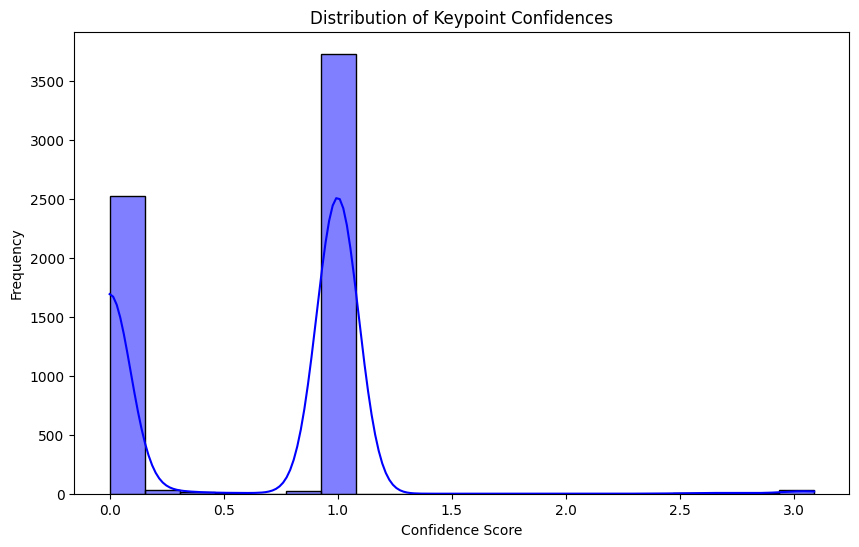

In [6]:
# Extract confidence values for all keypoints across frames
all_confidences = [frame[2::3] for frame in seq]  # Extract all confidence values (C) from seq
all_confidences = [value for sublist in all_confidences for value in sublist]  # Flatten the list

plt.figure(figsize=(10, 6))
sns.histplot(all_confidences, bins=20, kde=True, color="blue")
plt.title("Distribution of Keypoint Confidences")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.show()


#### 2. Heatmap of Keypoint Activit

**?Why?** Visualize the density of keypoint activity over a grid using a 2D heatmap for keypoint positions.

As the result we can see how many incorrect keypoints are in our datasets especially those that have 0 confidence (parts below hips) in the upper left corner

e:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


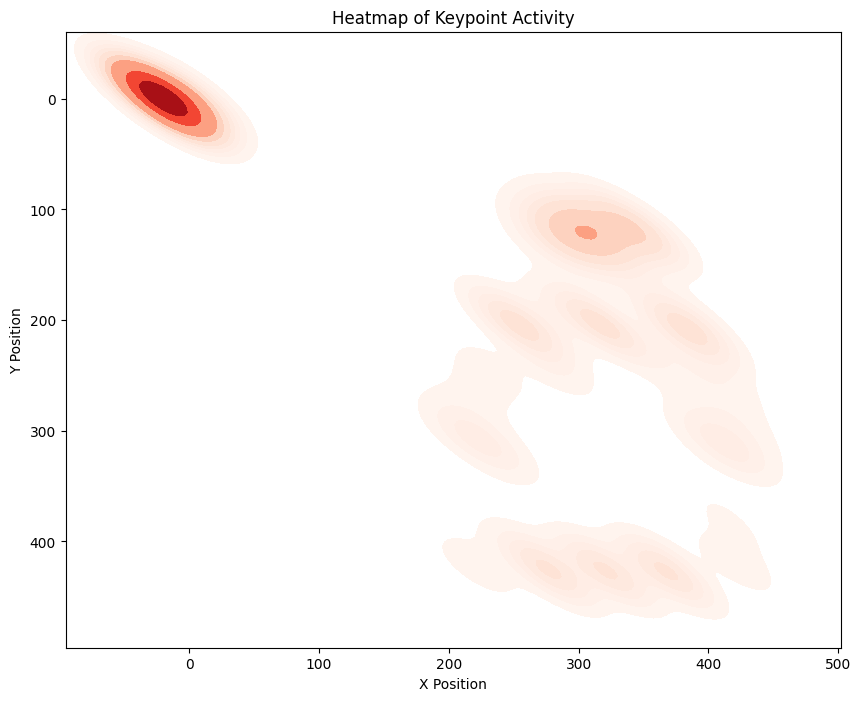

In [7]:
# first we filter out columns with angles to match the sizes of x and y
filtered_plot_seq = [frame for frame in seq if len(frame) % 3 == 0]
# Extract X and Y coordinates for all keypoints across frames in the sequence
all_x_coords = [frame[::3] for frame in filtered_plot_seq]  # Extract all X coordinates
all_y_coords = [frame[1::3] for frame in filtered_plot_seq]  # Extract all Y coordinates

# Flatten the lists
all_x_coords = [value for sublist in all_x_coords for value in sublist]
all_y_coords = [value for sublist in all_y_coords for value in sublist]

# Check if lengths match
assert len(all_x_coords) == len(all_y_coords), "Mismatch between X and Y coordinates!"

# Create 2D histograms of all keypoint positions
plt.figure(figsize=(10, 8))
sns.kdeplot(x=all_x_coords, y=all_y_coords, cmap="Reds", fill=True, bw_adjust=0.5)
plt.title("Heatmap of Keypoint Activity")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.gca().invert_yaxis()
plt.show()


#### 3. Scatter Plots for Keypoints
**?Why?** Show spatial distribution of keypoints plotting all keypoint positions across frames

Has quite the similar purpose as Heatmap plot, but here we can see keypoints distribution


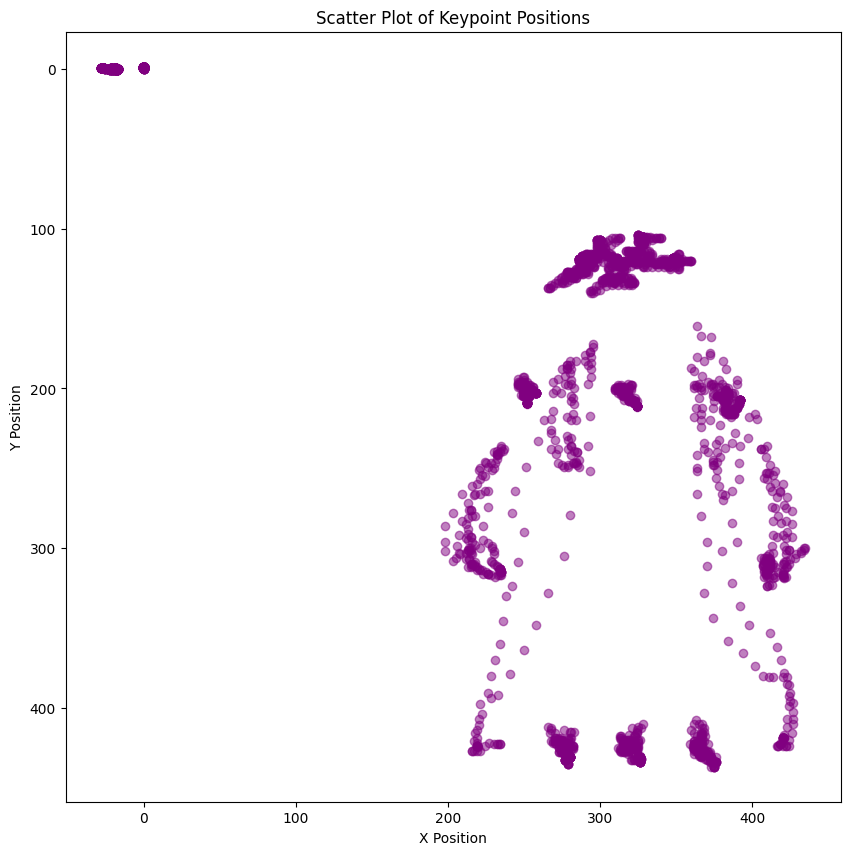

In [8]:

plt.figure(figsize=(10, 10))
plt.scatter(all_x_coords, all_y_coords, alpha=0.5, color="purple")
plt.title("Scatter Plot of Keypoint Positions")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.gca().invert_yaxis()  # Invert Y-axis for visual consistency
plt.show()



## Exercise 2: (Model) Design and Evaluation

Preprocess the data:

*– do you need to remove outliers from the training set?*

    Yes, we need because datasets contain some mistakes (parts with zero confidence scores), these should be removed.

    **However**, the train dataset contains the same mistakes which we are not allowed to remove, so we didn't remove 0 confidences from the train dataset. We only trim extra columns with angles.

*– do you need to perform normalization on the training/test set?*

    Yes, we need normalization for our datasets with keypoint coordinates.

<span style="color:blue"> We trained our model using RandomForestClassifier.</span>
 
 *Why?*
 - first of all, we were looking for the relatively simple (but power) model that would work good with 
 our table numerical datasets including classes;
 - in our datasets we also have feature importance (confidences) for each point. 
 Random forest understands which keypoints or derived statistics (e.g., mean X-coordinate, standard deviation) 
 are most critical for distinguishing actions;
 - it works good with table (structured) data;
 - it requires minimal preprocessing (so in our case we didn't scale data. we normalize it, but we got the same result as without normalization);
 - it works with categorical outputs (classes in our case);
 - works good with noisy data. it useful for us because in some sequences we have 0 confidences and missing keypoints;    

*What we could use for classification task instead?*
- Support Vector Machine (SVM):
However, it is not good for high-dimensional or large datasets and it requires careful preprocessing and tuning of kernels.
- Logistic Regression:
Limited in modeling nonlinear relationships between features.
- Deep Learning (e.g., LSTMs or CNNs):
It is more difficalt. May perform well for time-series data like motion sequences but requires significantly more data, preprocessing, and computational resources

In [9]:
# Import nesessary libraries:
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import LabelEncoder
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# We also tried to combine this models to improve generalization, but we got worse results in each step:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier


In [43]:
# here we create a new class for the the second task (partly similar as for the first one)
# the first 3 functions are identical to the first task
class DesignDataset:
    def __init__(self, train_dir="data/train", test_dir="data/test"):
        self.train_data = []
        self.train_labels = []
        self.test_data = []
        self.test_labels = []
        self._load_data(train_dir, "train")
        self._load_data(test_dir, "test")

    def _load_data(self, directory, dataset_type):
        for file_name in os.listdir(directory):
            if file_name.endswith(".csv"):
                subject, action, iteration = self._parse_file_name(file_name)
                if action not in valid_actions:
                    continue

                file_path = os.path.join(directory, file_name)
                sequence = self._load_csv(file_path)

                features = self._extract_features(sequence)
                if dataset_type == "train":
                    self.train_data.append(features)
                    self.train_labels.append(action)
                elif dataset_type == "test":
                    self.test_data.append(features)
                    self.test_labels.append(action)

    def _parse_file_name(self, file_name):
        base_name = file_name.rsplit(".", 1)[0]
        subject, action, iteration = base_name.split("_")
        return subject, action, int(iteration)

    def _load_csv(self, file_path):
        rows = []
        with open(file_path, "r") as f:
            for line in f:
                values = line.strip().split(",")
                if len(values) > 75:
                    values = values[:75]  # Trim extra columns
                elif len(values) < 75:
                    values.extend(["0.0"] * (75 - len(values)))  # Pad missing columns with zeros
                rows.append([float(value) for value in values])
        return np.array(rows)

    # extract features from each sequence:
    def _extract_features(self, sequence):
        x_coords = sequence[:, ::3]
        y_coords = sequence[:, 1::3]
        confidences = sequence[:, 2::3]

        features = []
        features.extend(np.mean(x_coords, axis=0))
        features.extend(np.mean(y_coords, axis=0))
        features.extend(np.std(x_coords, axis=0))
        features.extend(np.std(y_coords, axis=0))
        features.extend(np.mean(confidences, axis=0))
        # where:
            # - x_coords and y_coords are a 2D NumPy arrays that contains 
            # the X-coordinates and Y-coordinates of the keypoints in each frame of our dataset 
            # with the shape (num_frames, num_keypoints)
            # - np.mean() computes the mean of the values along a specified axis in the array
            # - axis=0 indicates that the mean is computed column-wise (across all frames for each keypoint)
            # This results in a 1D array where each element represents the average X-coordinate (or Y-coordinate) of a specific keypoint across all frames.
            # - np.std() computes the standard deviation of the values along the specified axis

        
        return np.array(features)

    # return all nesessary data:
    def get_train_test_data(self):
        return (
            np.array(self.train_data),
            np.array(self.train_labels),
            np.array(self.test_data),
            np.array(self.test_labels),
        )

# setting rundom seed for our random forest classifier helps us in some case like:
    # - Enables fair comparisons between multiple iterations
    # - This ensures that randomness (in Random Forest) 
    # is different for each run but still controlled and reproducible.
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

# train model using RandomForestClassifier:
def train_and_evaluate(X_train, y_train, X_test, y_test, label_encoder):
    model = RandomForestClassifier(
        n_estimators=110,            # Increase number of trees
        max_depth=17,                # Allow deeper trees
        min_samples_split=10,        # Require more samples to split
        min_samples_leaf=2,          # Require more samples per leaf
        random_state=random.randint(0, 10000),  # Random seed for reproducibility
    )
    
    model.fit(X_train, y_train) # Trains the Random Forest Classifier using the training data (X_train) and corresponding labels (y_train)
    # Random Forest Training:
        # - The model creates multiple decision trees.
        # - Each tree is trained on a random subset of X_train (bootstrap sampling).++
        # - At each node in a tree, a random subset of features is used to determine the best split.

    y_pred = model.predict(X_test) # here we use the trained model to predict the class labels for the test data (X_test) - unseen data

    cm = confusion_matrix(y_test, y_pred) # computes the confusion matrix, which provides a summary of how well 
                                            # the model’s predictions (y_pred) match the true labels (y_test)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_) # generates a detailed classification report 
                                            # that summarizes the performance of a classification model. It gives:
                                                # - Precision: The ratio of correctly predicted positive observations to the total predicted positive observations;
                                                # - Recall: The ratio of correctly predicted positive observations to all observations in the actual class;
                                                # - F1-Score: The harmonic mean of precision and recall;
                                                # - Support: The number of true instances for each class in y_test;
                                                # - Accuracy: The overall ratio of correctly predicted samples to the total number of samples;
                                                # - Macro Average: Unweighted mean of precision, recall, and F1-score across all classes;
                                                # - Weighted Average: Weighted mean of precision, recall, and F1-score, with weights based on the support (number of samples) for each class.
    
    print("Classification Report:")
    print(report)

    return accuracy_score(y_test, y_pred), cm, report

# here we run experiments and display result:
def run_experiments(X_train, y_train, X_test, y_test, label_encoder, num_runs=5):
    accuracies = []
    confusion_matrices = []
    reports = []

    for run in range(num_runs): # use num_runs to get different results each iteration for further comparition
        print(f"Run {run + 1}/{num_runs}")

        set_random_seed(run) # set random seed for reproducibility

        # Train and evaluate:
        accuracy, cm, report = train_and_evaluate(X_train, y_train, X_test, y_test, label_encoder) # get accuracy, confusion matrix, and full classification report
        
        # append all info in the appropriate array:
        accuracies.append(accuracy)
        confusion_matrices.append(cm)
        reports.append(report)


        mean_accuracy = np.mean(accuracies) # calculate the mean accuracy (average accuracy over all runs)
        std_accuracy = np.std(accuracies) # computes the standard deviation of the accuracy scores, which measures the spread or variability of the accuracies across runs

        # display all nesessary info:
        print(f"Run {run + 1} Accuracy: {accuracy:.4f}")
        print(f"Mean Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")
        print("----------------------------------------------")
        
    max_accuracy = np.max(accuracies) # find the maximum accuracy along all steps
    max_index = np.argmax(accuracies)
    print(f"Maximum Accuracy: {max_accuracy:.4f}")
    
    # Print classification report for the run with maximum accuracy
    print("Classification Report for Maximum Accuracy:")
    print(reports[max_index])

    # Plot confusion matrix for the run with maximum accuracy
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[max_index], display_labels=label_encoder.classes_).plot()
    plt.title("Confusion Matrix for Maximum Accuracy")
    plt.show()

    return accuracies


Classes: ['boxing' 'drums' 'guitar' 'rowing' 'violin']
Run 1/5
Classification Report:
              precision    recall  f1-score   support

      boxing       0.83      0.87      0.85        60
       drums       0.92      0.76      0.83        62
      guitar       0.96      0.84      0.89        61
      rowing       0.92      1.00      0.96        61
      violin       0.83      0.98      0.90        61

    accuracy                           0.89       305
   macro avg       0.89      0.89      0.89       305
weighted avg       0.89      0.89      0.89       305

Run 1 Accuracy: 0.8885
Mean Accuracy: 0.8885 ± 0.0000
----------------------------------------------
Run 2/5
Classification Report:
              precision    recall  f1-score   support

      boxing       0.85      0.87      0.86        60
       drums       0.85      0.74      0.79        62
      guitar       0.91      0.80      0.85        61
      rowing       0.95      1.00      0.98        61
      violin       0.8

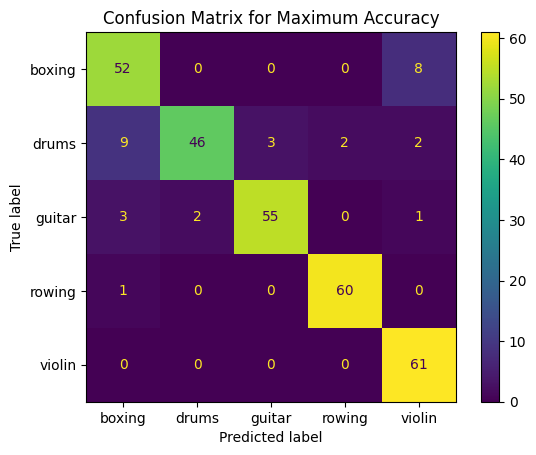

In [44]:
# execution of the class:
if __name__ == "__main__":
    # Load dataset
    dataset_design = DesignDataset(train_dir="data/train", test_dir="data/test")
    X_train, y_train, X_test, y_test = dataset_design.get_train_test_data()
    
    # normalize data (ensures all features are on the same scale, so no single feature dominates the model due to larger values):
    # normalization is not nesessary for random forest, so removing normalization doesn't change results almost at all.
    scaler = StandardScaler() # StandardScaler and MinMaxScaler give us the same result
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Encode labels:
    label_encoder = LabelEncoder()
    y_train = label_encoder.fit_transform(y_train) #Standardizes the training data (X_train) by: fit(): Calculates the mean (𝜇) 
                                                    # and standard deviation (𝜎) for each feature in the training data.
                                                    # transform(): Applies the standardization formula to each feature in X_train.
    
    y_test = label_encoder.transform(y_test) # Standardizes the test data (X_test) using the mean and standard deviation calculated from the training data during fit()
    
   

    print("Classes:", label_encoder.classes_)

    # Run experiments and evaluate:
    run_experiments(X_train, y_train, X_test, y_test, label_encoder)


In [12]:
# Check the shape of the processed training and test data:
X_train, y_train, X_test, y_test = dataset_design.get_train_test_data()
print("Train Data Shape:", X_train.shape)
print("Train Labels Shape:", y_train.shape)
print("Test Data Shape:", X_test.shape)
print("Test Labels Shape:", y_test.shape)

Train Data Shape: (1167, 125)
Train Labels Shape: (1167,)
Test Data Shape: (305, 125)
Test Labels Shape: (305,)


## Results and explanation 
#### (However, the most explanation in commets in code)


<span style="color:blue"> **The best result we got:**</span>

Run 5/5
Classification Report:

              precision    recall  f1-score   support

      boxing       0.80      0.87      0.83        60
       drums       0.96      0.74      0.84        62
      guitar       0.95      0.90      0.92        61
      rowing       0.97      0.98      0.98        61
      violin       0.85      1.00      0.92        61

    accuracy                           0.90       305

   macro avg       0.90      0.90      0.90       305

weighted avg       0.90      0.90      0.90       305

Run 5 Accuracy: 0.8984

Mean Accuracy: 0.8800 ± 0.0125

<span style="color:blue"> using following hyperparameters:</span>


        model = RandomForestClassifier(

                n_estimators=110,

                max_depth=17,

                min_samples_split=10,

                min_samples_leaf=2,

                random_state=random.randint(0, 10000),
        
        )

<span style="color:blue"> Why did we use these parameters?</span>

-n_estimators=110 - Specifies the number of decision trees in the forest. Too many trees can increase computational cost without significant gains after a certain point. A moderate number of trees (e.g., 100–200) often provides a good balance between accuracy. We tried numbers in range (50 - 700), but the range (100-200) gives the best results.
- max_depth=17 - Sets the maximum depth of each tree (controls how many splits a tree can make from the root to a leaf) - the optimal value depends on the data's complexity, so for 1167 samples in our dataset depth of 15-20 is an optimal (we compaired with a rnage (10-60)), it allows trees to be sufficiently expressive for our dataset while avoiding extreme overfitting. 
Following the presentation, we revisited your question, that you mentioned before, regarding the maximum depth of trees in our hyperparameters. Initially, we used a max_depth of 30, which allowed us to process approximately 1000 values. To explore further, we tested larger values (e.g., max_depth = 40 and 50) to determine the impact on our dataset of 1167 samples.

Our analysis showed that increasing max_depth to 50 provided sufficient expressiveness for our dataset without causing overfitting. However, the average accuracy remained unchanged across the range of values tested. Testing in range 15-20 we achieve the best result 0.88 using 17. This confirms that max_depth = 17 is sufficient for processing our dataset and offers an optimal balance between performance and model complexity. Despite adjusting the parameter to higher values (e.g., 50), the results stayed consistent. Therefore, we concluded that max_depth = 17 is appropriate for our dataset of 1167 values.
- min_samples_split=10 - Specifies the minimum number of samples required to split an internal node (ensure splits occur only when sufficient data is available to justify the split) - the best results was reached in 10 and 14.
- min_samples_leaf=2 - Specifies the minimum number of samples required to be at a leaf node (prevents the creation of leaf nodes with very few samples) - 2 helps avoid overfitting while still capturing enough detail.
- random_state=random.randint(0, 10000) - Sets the seed for the random number generator (Generates a unique random seed for each experiment. This ensures varied results across iterations, which is useful for evaluating model robustness)

